In [12]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from bootstrap_function import perform_bootstrap
from scipy.stats import ks_2samp

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

sns.set_theme()
sns.set_context("talk")

# Hepatocellular Carcinoma Cell Speed Tracking

6 Cell Lines
<ul>
    <li> JHH4
    <li> JHH6
    <li> Huh7
    <li> JHH7
    <li> PRF5
    <li> Kami41
</ul>

# 1. Perform segmentation on raw microscopy images using iLastik

In [8]:
raw_video_path = './assets/raw_JHH4_A2.avi'
segmented_video_path = './assets/segmented_JHH4_A2.avi'
tracked_video_path = './assets/TrackMate capture of JHH4_A2.avi'

HTML("""<video width="840" height="460" controls=""><source src="{0}"></video>""".format(raw_video_path))

In [9]:
HTML("""<video width="840" height="460" controls=""><source src="{0}"></video>""".format(segmented_video_path))

# 2. Perform spot identification and tracking with TrackMate (Fiji Plugin)

Spot identification algorithm assigns X and Y coordinate values for each segmented cell<br>
LAP Tracking algorithm connects each spot to forms tracks<br>
Each image series produces spot, link, and track data which can be analyzed

In [10]:
HTML("""<video width="840" height="460" controls=""><source src="{0}"></video>""".format(tracked_video_path))

# 3. Analyze track data

Track data includes many features such as minimum, maximum, mean, median, and standard deviation of track speed for each track.

In [13]:
df = pd.read_csv('master_df_3.csv')
df = df.drop(df.columns[0], axis=1)
df

,IMAGE_SERIES,Label,TRACK_ID,NUMBER_SPOTS,NUMBER_GAPS,LONGEST_GAP,NUMBER_SPLITS,NUMBER_MERGES,NUMBER_COMPLEX,TRACK_DURATION,...,TRACK_MAX_SPEED,TRACK_MIN_SPEED,TRACK_MEDIAN_SPEED,TRACK_STD_SPEED,TRACK_MEAN_QUALITY,TRACK_MAX_QUALITY,TRACK_MIN_QUALITY,TRACK_MEDIAN_QUALITY,TRACK_STD_QUALITY,cell_line
0,PRF5_B3_pickup,Track_0,0,12,0,0,0,0,0,11,...,29.000,1.000,10.000,9.781,0.093,0.123,0.059,0.100,0.017,PRF5
1,PRF5_B3_pickup,Track_1,1,10,0,0,0,0,0,9,...,2.000,0.000,1.000,0.928,0.087,0.116,0.040,0.094,0.023,PRF5
2,PRF5_B3_pickup,Track_2,2,3,0,0,0,0,0,2,...,4.000,2.000,4.000,1.414,0.067,0.075,0.056,0.070,0.008,PRF5
3,PRF5_B3_pickup,Track_3,3,7,0,0,0,0,0,6,...,12.837,2.459,6.725,3.562,0.096,0.100,0.094,0.096,0.002,PRF5
4,PRF5_B3_pickup,Track_4,4,3,0,0,0,0,0,2,...,15.758,7.837,15.758,5.601,0.075,0.080,0.071,0.073,0.004,PRF5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28951,JHH4 C2 Pickup,Track_562,171,28,1,2,0,0,0,29,...,12.144,1.261,3.776,2.951,20.357,30.860,0.938,23.666,8.401,JHH4
28952,JHH4 C2 Pickup,Track_563,172,24,1,2,0,0,0,25,...,26.095,0.513,6.390,7.976,11.447,22.958,0.681,11.079,6.412,JHH4
28953,JHH4 C2 Pickup,Track_571,180,17,0,0,0,0,0,16,...,39.380,0.910,10.010,9.622,13.101,20.086,8.683,10.978,4.414,JHH4
28954,JHH4 C2 Pickup,Track_578,187,7,0,0,0,0,0,6,...,32.209,8.133,15.220,9.544,1.150,1.464,0.510,1.325,0.317,JHH4


# 3a. Distribution analysis of all cell lines

<ul>
<li>Kernel density estimate<br>
<li>Kolmogorov-Smirnov value matrix<br>
</ul>

Values are normalized by bootstrapping

max_length:  7331


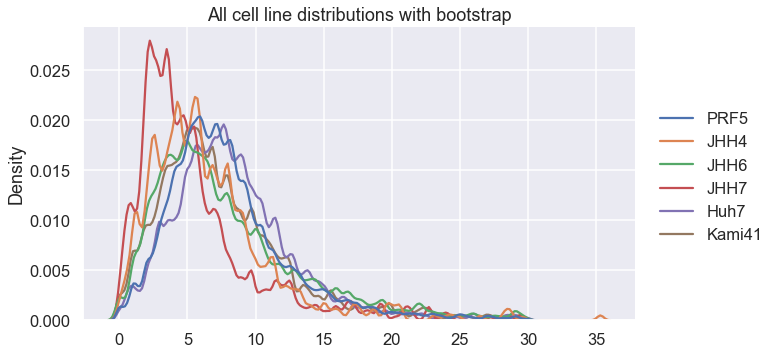

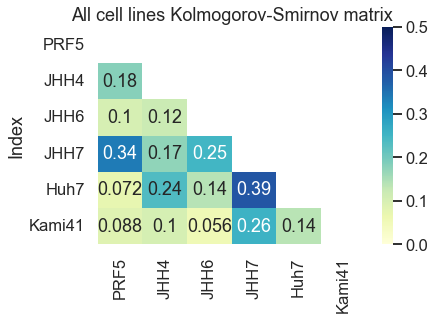

In [15]:
non_treatment_lines = ['PRF5', 'JHH4', 'JHH6', 'JHH7', 'Huh7', 'Kami41']
non_treatment_df = df[df.cell_line.isin(non_treatment_lines)]
non_treatment_df = non_treatment_df.reset_index(drop=True)

def all_line_bootstrap(dataframe):
    cell_line_df = dataframe
    TRACK_MEAN_SPEED_df = cell_line_df[['TRACK_MEAN_SPEED', 'cell_line']]
    cell_line_list = TRACK_MEAN_SPEED_df.cell_line.unique()

    # perform loop to identify max length for all image series for this cell line
    max_length = 0
    for series in cell_line_list:
        series = TRACK_MEAN_SPEED_df[TRACK_MEAN_SPEED_df['cell_line'] == series]
        series_length = len(series)
        if series_length > max_length:
            max_length = series_length
        else:
            pass

    print('max_length: ', max_length)
    bootstrap_dict = {}

    # next, use the max length to bootstrap values for any series with fewer values than the max length
    for series in cell_line_list:
        series_values = TRACK_MEAN_SPEED_df[TRACK_MEAN_SPEED_df['cell_line'] == series]['TRACK_MEAN_SPEED']
        series_length = len(series_values)
        if series_length < max_length:
            x = np.random.choice(series_values, size=max_length, replace=True)
            bootstrap_dict[series] = x
        elif series_length == max_length:
            bootstrap_dict[series] = series_values
        else:
            print('Series length error')
    return bootstrap_dict

bootstrap_dict = all_line_bootstrap(dataframe=non_treatment_df)
bootstrap_df = pd.DataFrame.from_dict(bootstrap_dict)
bootstrap_df = bootstrap_df.reset_index(drop=True)
bootstrap_df

# calculate Kolmogorov-Smirnov
series_list = bootstrap_df.columns
ks_values = []
# calculate KS values
for i in range(len(series_list)):
    results_list = [series_list[i]]
    for j in range(len(series_list)):
        p = series_list[i]
        q = series_list[j]
        comparison = p + " x " + q
        p = bootstrap_df[p]
        q = bootstrap_df[q]
        ks_result = ks_2samp(p, q)[0]
        results_list.append(ks_result)

    ks_values.append(results_list)

# convert to dataframe
ks_df = pd.DataFrame(ks_values, columns = ['Index', series_list[0], series_list[1], series_list[2], 
                                        series_list[3], series_list[4], series_list[5]])
ks_df = ks_df.set_index('Index')
# plot distribution
sns.displot(bootstrap_df, kind="kde", bw_adjust=.3, 
            height=5, aspect=15/8).set(title='All cell line distributions with bootstrap')
# plt.savefig('./images/all_cell_lines_kde.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

with sns.axes_style("white"):
    mask = np.zeros_like(ks_df)
    mask[np.triu_indices_from(mask)] = True    
    sns.heatmap(ks_df, annot=True, mask=mask, vmin=0, vmax=0.5, 
                cmap="YlGnBu").set(title='All cell lines Kolmogorov-Smirnov matrix')
#     plt.savefig('./images/all_cell_lines_kde_ks_heatmap.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [17]:
def all_line_bootstrap(dataframe):
    cell_line_df = dataframe
    TRACK_MEAN_SPEED_df = cell_line_df[['TRACK_MEAN_SPEED', 'cell_line']]
    cell_line_list = TRACK_MEAN_SPEED_df.cell_line.unique()

    # perform loop to identify max length for all image series for this cell line
    max_length = 0
    for series in cell_line_list:
        series = TRACK_MEAN_SPEED_df[TRACK_MEAN_SPEED_df['cell_line'] == series]
        series_length = len(series)
        if series_length > max_length:
            max_length = series_length
        else:
            pass

    print('max_length: ', max_length)
    bootstrap_dict = {}

    # next, use the max length to bootstrap values for any series with fewer values than the max length
    for series in cell_line_list:
        series_values = TRACK_MEAN_SPEED_df[TRACK_MEAN_SPEED_df['cell_line'] == series]['TRACK_MEAN_SPEED']
        series_length = len(series_values)
        if series_length < max_length:
            x = np.random.choice(series_values, size=max_length, replace=True)
            bootstrap_dict[series] = x
        elif series_length == max_length:
            bootstrap_dict[series] = series_values
        else:
            print('Series length error')

    return bootstrap_dict

def all_distribution_and_ks(data):    
    bootstrap_dict = all_line_bootstrap(dataframe=data)
    bootstrap_df = pd.DataFrame.from_dict(bootstrap_dict)
    bootstrap_df = bootstrap_df.reset_index(drop=True)
    bootstrap_df

    # calculate Kolmogorov-Smirnov
    series_list = bootstrap_df.columns
    ks_values = []
    # calculate KS values
    for i in range(len(series_list)):
        results_list = [series_list[i]]
        for j in range(len(series_list)):
            p = series_list[i]
            q = series_list[j]
            comparison = p + " x " + q
            p = bootstrap_df[p]
            q = bootstrap_df[q]
            ks_result = ks_2samp(p, q)[0]
            results_list.append(ks_result)

        ks_values.append(results_list)

    # convert to dataframe
    ks_df = pd.DataFrame(ks_values, columns = ['Index', series_list[0], series_list[1], series_list[2], 
                                            series_list[3], series_list[4], series_list[5]])
    ks_df = ks_df.set_index('Index')
    # plot distribution
    sns.displot(bootstrap_df, kind="kde", bw_adjust=.3, 
                height=5, aspect=15/8).set(title='Treatment condition distributions with bootstrap')
#     plt.savefig('./images/treatment_cell_lines_kde.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    with sns.axes_style("white"):
        mask = np.zeros_like(ks_df)
        mask[np.triu_indices_from(mask)] = True    
        sns.heatmap(ks_df, annot=True, mask=mask, vmin=0, vmax=0.5, 
                    cmap="YlGnBu").set(title='All cell lines Kolmogorov-Smirnov matrix')
#         plt.savefig('./images/treatment_cell_lines_kde_ks_heatmap.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.show()



['JHH6_0uM', 'JHH6_1uM', 'JHH6_2.5uM', 'JHH7_0uM', 'JHH7_1uM', 'JHH7_2.5uM']
max_length:  5633


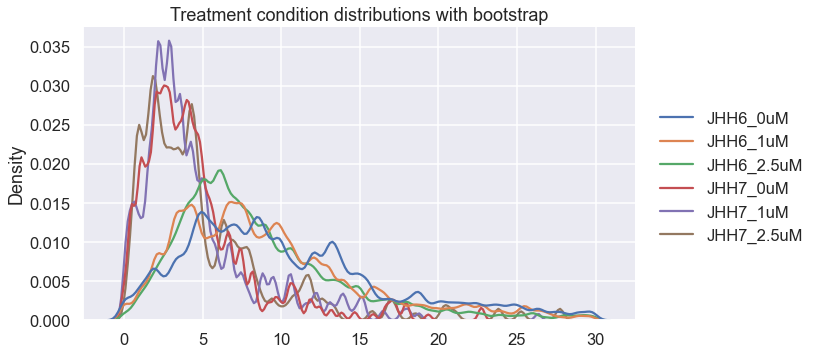

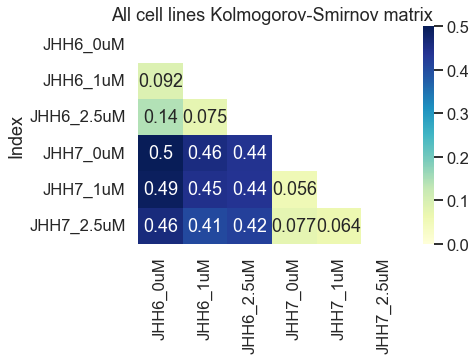

In [18]:
treatment_lines = ['JHH7_2.5uM', 'JHH6_2.5uM', 'JHH7_0uM', 'JHH6_0uM', 'JHH7_1uM', 'JHH6_1uM']
treatment_lines.sort()
print(treatment_lines)
treatment_df = df[df.cell_line.isin(treatment_lines)]
treatment_df = treatment_df.sort_values('IMAGE_SERIES')
treatment_df = treatment_df.reset_index(drop=True)

all_distribution_and_ks(treatment_df)

# 3b. Distribution analysis of individual lines
